# Block bootstrapping technique
Block bootstrapping is a resampling technique commonly used in time series analysis to account for autocorrelation structure in the data. By preserving the correlation within blocks of data, it provides a more accurate representation of the underlying processes. This technique can be used to calculate confidence intervals, which help quantify the uncertainty in our estimate. When comparing verification metrics of two forecast systems, these confidence intervals enable us to assess the statistical significance of their differences, helping determine which system performs better with greater reliability.

Block bootstrapping function available in `scores` includes an optional argument that allows one to specify whether the resampling should be done circularly. Circular block bootstrapping treats data as circular, enabling blocks to wrap around from the end of the series back to the beginning. This means that points on the edges have the same probability of being sampled as points in the middle of the array.This method is particularly useful for cyclical or seasonal time series data, where the end of the series naturally follows the beginning. Additionally, it helps maintain the continuity and dependence structure of the data.

Similar to the **[Diebold Mariano (DM) test](./Diebold_Mariano_Test_Statistic.ipynb)**, the block bootstrapping technique does not require forecast errors to be Gaussian. Since it is a non-parametric resampling method, it does not rely on specific distributional assumptions.This characteristic, along with its ability to handle serially correlated scores, makes block bootstrapping a suitable method for calculating confidence intervals compared to compared to traditional statistical techniques.

## References
Gilleland, E. (2020). Bootstrap Methods for Statistical Inference. Part I: Comparative Forecast Verification for Continuous Variables. Journal of Atmospheric and Oceanic Technology, 37(11), 2117–2134. https://doi.org/10.1175/jtech-d-20-0069.1

Wilks, D. S. (2011). Statistical methods in the atmospheric sciences. Academic press. https://doi.org/10.1016/C2017-0-03921-6


Here we show an example of using block bootstrapping to calculate the confidence that one forecast system performed better than another.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from scores.processing import block_bootstrap
from scores.continuous import mse

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

Let's generate some synthetic observations and two corresponding synthetic forecasts.

In [2]:
# Create synthetic observations (here temperature) for a 50x50 grid over January in 2023
n_time = 31
n_x = n_y = 50
n_lead_day = 5
np.random.seed(42)
obs = 20 + xr.DataArray(
    data=np.random.randn(n_time, n_x, n_y).cumsum(axis=0),
    dims=["time", "x", "y"],
    coords={"time": pd.date_range("2023-01-01", "2023-01-31"), "x": np.arange(n_x), "y": np.arange(n_y)},
    name="temperature",
)
obs.values = gaussian_filter(obs.values, sigma=1)
fcst = xr.DataArray(data=[1] * n_lead_day, dims="lead_day", coords={"lead_day": np.arange(1, n_lead_day + 1)})
fcst = fcst * obs

# Create two synthetic forecasts that are based on the observations + noise
# Here, we consider a larger noise for forecast system B
fcst_a = fcst + np.random.randn(n_lead_day, n_time, n_x, n_y) * 0.5
fcst_b = fcst + np.random.randn(n_lead_day, n_time, n_x, n_y) * 2

# Reduce skill with lead time
fcst_a.values = fcst_a.values + (np.linspace(0, 0.5, n_lead_day)[:, None, None, None])
fcst_b.values = fcst_b.values + (np.linspace(0, 0.5, n_lead_day)[:, None, None, None])

# Add dependence back in
fcst_a.values = gaussian_filter(fcst_a.values, sigma=0.7)
fcst_b.values = gaussian_filter(fcst_b.values, sigma=1)

Let's now visualise the forecasts and observations for a timestep. We can see that there is some spatial dependence.

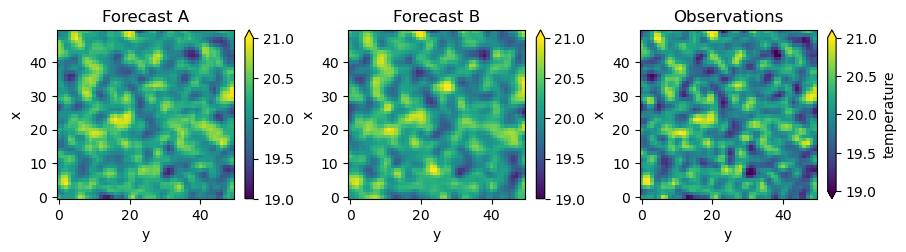

In [3]:
VMIN = 19
VMAX = 21
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))

fcst_a.isel(lead_day=1, time=1).plot(ax=axes[0], vmax=VMAX, vmin=VMIN)
axes[0].set_title("Forecast A")

fcst_b.isel(lead_day=1, time=1).plot(ax=axes[1], vmax=VMAX, vmin=VMIN)
axes[1].set_title("Forecast B")

obs.isel(time=1).plot(ax=axes[2], vmax=VMAX, vmin=VMIN)
axes[2].set_title("Observations")

plt.tight_layout()
fig.set_size_inches(9, 2)
plt.show()

Now let's do some block bootstrapping. We use block size of 10 for `x` and `y` dimensions and 6 for `time` dimension. Additionally, we exclude `"lead_day"` dimension from our bootstrapping process. 

In [4]:
fcst_a_block_boot, fcst_b_block_boot, obs_block_boot = block_bootstrap(
    [fcst_a, fcst_b, obs],
    blocks={"x": 10, "y": 10, "time": 6},
    exclude_dims=[["lead_day"], ["lead_day"], []],
    n_iteration=100,
    circular=True,
)

In [5]:
fcst_a_mse_block = mse(fcst_a_block_boot, obs_block_boot, preserve_dims=["lead_day", "iteration"])
fcst_b_mse_block = mse(fcst_b_block_boot, obs_block_boot, preserve_dims=["lead_day", "iteration"])

In [6]:
diff = fcst_a_mse_block - fcst_b_mse_block
mean = diff.mean(dim="iteration")
lower_band = diff.quantile(0.05, dim="iteration")
upper_band = diff.quantile(0.95, dim="iteration")

Here, we can also visualise the mean difference in MSE of these two systems along with 90% confidence bands. This figure clearly shows that forecast system A (as we expected) performed batter than forecast system B ($MSE_A < MSE_B$) at the 10% significance level.

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=mean.lead_day.values, y=mean.values, mode="lines", name="Mean difference"))
fig.add_trace(
    go.Scatter(
        x=mean.lead_day.values, y=upper_band.values, fill=None, mode="lines", line_color="lightgrey", showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        x=mean.lead_day.values,
        y=lower_band.values,
        fill="tonexty",
        mode="lines",
        line_color="lightgrey",
        name="90% Confidence intervals",
    )
)

fig.update_layout(
    title="Difference in the mean MSE of forecast systems<br>A and B (MSE<sub>A</sub> - MSE<sub>B</sub>)",
    xaxis_title="Lead day",
    yaxis_title="MSE difference",
    width=600,
    height=500,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

# Important note
- Traditionally block sizes have often been chosen as the square root of the length dimension. However it is important that "...block lengths should be chosen to be much longer than the length of dependence, but much shorter than the entire series" ([Gilleland 2020](https://doi.org/10.1175/JTECH-D-20-0069.1)).

# Things to try next
- Generate some more synthetic data with different dependency structures and explore the impact of block sizing
- Try block bootstrapping on real data